<a href="https://colab.research.google.com/github/YinGuoX/Deep_Learning_Pytorch_WithDeeplizard/blob/master/28_CNN_Confusion_Matrix_With_PyTorch_Neural_Network_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create A Confusion Matrix With PyTorch
 在本节中，我们将构建一些函数，这些函数将使我们能够为训练集中的每个样本获取预测张量。

 然后，我们将看到如何使用这个预测张量以及每个样本的标签来创建混淆矩阵。这个混淆矩阵将允许我们看到我们的网络中哪些类别相互混淆。不用再麻烦了，我们开始吧。

我们现在所处的阶段:

* 准备数据

* 建立模型

* 训练模型

* 分析模型的结果
  * **建立，绘制和解释混淆矩阵**

有关所有代码设置的详细信息，请务必参阅上一节。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4,out_features=120)
    self.fc2 = nn.Linear(in_features=120,out_features=60)
    self.out = nn.Linear(in_features=60,out_features=10)



  def forward(self,t):
    t= t;


    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t,kernel_size=2,stride=2)

    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t,kernel_size=2,stride=2)

    t = t.reshape(-1,12*4*4)
    t = self.fc1(t)
    t = F.relu(t)
    
    t = self.fc2(t)
    t = F.relu(t)

    t = self.out(t)
    return t;

In [ ]:
train_set = torchvision.datasets.FashionMNIST(root='./data',train=True,
                                download=True,
                                transform=transforms.Compose([
        transforms.ToTensor()
    ]))


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
def get_num_correct(preds,labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
network  = Network()

train_loader = torch.utils.data.DataLoader(
   train_set,
   batch_size=100,
   shuffle=True 
)

optimiter = optim.Adam(network.parameters(),lr=0.0001)

In [ ]:
for epoch in range(10):
  total_loss = 0
  total_correct = 0
  for batch in train_loader:
    images,labels = batch

    preds = network(images)
    loss = F.cross_entropy(preds,labels)

    optimiter.zero_grad()
    loss.backward()
    optimiter.step()

    total_loss += loss.item()
    total_correct+=get_num_correct(preds,labels)
  
  print(
      "epoch:",epoch,
      "total_loss:",total_loss,
      "total_correct:",total_correct
  )
    


epoch: 0 total_loss: 823.4279091954231 total_correct: 32442
epoch: 1 total_loss: 450.96173518896103 total_correct: 42996
epoch: 2 total_loss: 405.6564346551895 total_correct: 44536
epoch: 3 total_loss: 379.9148697257042 total_correct: 45408
epoch: 4 total_loss: 360.8149921298027 total_correct: 46176
epoch: 5 total_loss: 346.77783676981926 total_correct: 46715
epoch: 6 total_loss: 334.824419349432 total_correct: 47236
epoch: 7 total_loss: 323.95701575279236 total_correct: 47817
epoch: 8 total_loss: 315.60204499959946 total_correct: 48221
epoch: 9 total_loss: 307.137815952301 total_correct: 48586


## 1.混淆矩阵要求

为了为整个数据集创建一个混淆矩阵，我们需要一个预测张量，该张量的单个维度与训练集的长度相同。

In [ ]:
len(train_set)

60000

对于我们训练集中的每个样本，此预测张量将包含十个预测（每种服装类别一个）。 获得此张量后，可以使用标签张量生成混淆矩阵。

In [ ]:
len(train_set.targets)

60000

混淆矩阵将向我们展示模型混淆的地方。更具体地说，混淆矩阵将向我们显示模型正确预测的类别以及模型错误预测的类别。对于不正确的预测，我们将能够看到模型预测了哪些类别，这将向我们展示哪些类别混淆了模型。

## 2.获得整个训练集的预测

为了获得所有训练集样本的预测，我们需要将所有样本通过网络的正向传播。 为此，可以创建一个具有batch_size = 1的DataLoader。 这将立即将单个批次传递到网络，并将为我们提供所有训练集样本所需的预测张量。

但是，如果要在不同的数据集上进行训练，则取决于计算资源和训练集的大小，我们需要一种方法来对较小的批次进行预测并收集结果。 为了收集结果，我们将使用torch.cat（）函数将输出张量连接在一起，以获得单个预测张量。 让我们构建一个函数来执行此操作。

### 构建函数以获取所有样本的预测
---
我们将创建一个名为get_all_preds（）的函数，并传递一个模型和一个数据加载器。模型将用于获得预测，数据加载器将用于提供训练集中的批。

该函数需要做的就是遍历数据加载器，将批传递给模型，并将每个批的预测结果连接到一个将返回给调用者的预测张量。

In [ ]:
# @torch.no_grad()
def get_all_preds(model,loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images,labels = batch
    preds = model(images)

    all_preds = torch.cat((all_preds,preds),dim=0)

  return all_preds

此函数会创建一个空张量all_preds来保存输出预测。 然后，迭代来自数据加载器的批处理，并将输出预测与all_preds张量连接在一起。 最后，所有预测all_preds将返回给调用方。

**注意：**在顶部，我们已使用@torch.no_grad（）PyTorch装饰对函数进行了注释。 这是因为我们希望该函数执行省略梯度跟踪。

这是因为梯度跟踪占用内存，并且在预测（在不训练的情况下获得预测）期间，无需跟踪计算图。 装饰器是在执行特定功能时局部关闭计算图跟踪功能的一种方法。

### 局部禁用梯度跟踪
---
我们现在准备好调用以获取训练集的预测。我们需要做的就是创建一个具有合理批量大小的数据加载器，并将模型和数据加载器传递给get_all_preds（）函数。

在前几节中，我们看到了用户如何在不需要PyTorch的梯度跟踪功能时将其关闭，并在开始训练过程时将其重新打开。

每当我们要使用backward（）函数计算梯度时，我们特别需要梯度计算功能。否则，关闭它是个好主意，因为关闭它将减少计算的内存消耗，例如当我们使用网络进行预测（推理）时。

我们也可以在我们的代码中禁用特定或局部点的梯度计算，例如，就像我们刚才看到的带注释的函数一样。作为另一个例子，我们可以使用Python的with关键字来指定指定的代码块应该取消梯度计算。

In [ ]:
with torch.no_grad():
  prediction_loader = torch.utils.data.DataLoader(train_set,batch_size=10000)
  train_preds = get_all_preds(network,prediction_loader)

这两个选项都有效。让我们保留这两个并得到我们的预测。

### 使用预测张量
---

现在，有了预测张量，我们可以将其传递给我们在上一集中创建的get_num_correct（）函数以及训练集标签，以获取正确预测的总数。

In [ ]:
preds_correct = get_num_correct(train_preds,train_set.targets)


In [ ]:
print("total correct:",preds_correct)
print("accuracy:",preds_correct/len(train_set))

total correct: 48849
accuracy: 0.81415


我们可以看到正确预测的总数，并通过除以训练集中的样本数来打印准确性。

## 3.建立混乱矩阵

我们构建混淆矩阵的任务是将预测值的数量与真实值（目标）进行计数。

这将创建一个充当热图的矩阵，告诉我们预测值相对于真实值的下降位置。

为此，我们需要具有train_preds张量中的目标张量和预测标签

In [ ]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
train_preds.argmax(dim=1)

tensor([9, 0, 3,  ..., 3, 0, 5])

现在，如果我们在元素方面比较两个张量，我们可以看到预测的标签是否与目标匹配。另外，如果我们计算预测标签和目标标签的数量，那么两个张量中的值将作为矩阵的坐标。让我们把这两个张量沿着第二维叠加，这样我们就可以有60000个有序对。

In [ ]:
stacked = torch.stack(
    (train_set.targets,
    train_preds.argmax(dim=1)),
    dim=1

)

In [ ]:
stacked.shape

torch.Size([60000, 2])

In [ ]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 3],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [ ]:
stacked[0].tolist()

[9, 9]

现在，我们可以遍历这些对，并计算矩阵中每个位置的出现次数。 让我们创建矩阵。 由于我们有十个预测类别，因此将有一个十乘十的矩阵。

In [ ]:
cmt = torch.zeros(10,10,dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

现在，我们将遍历预测目标对，并在每次发生特定位置时向矩阵内的值添加一个。

In [ ]:
for p in stacked:
  t1,p1 = p.tolist()
  cmt[t1,p1]=cmt[t1,p1]+1

这为我们提供了以下混淆矩阵张量。

In [ ]:
cmt

tensor([[4711,   10,   58,  588,   40,   16,  501,    1,   73,    2],
        [   0, 5742,    0,  179,   31,    3,   43,    0,    2,    0],
        [  49,    8, 3666,   71, 1019,   11, 1082,    0,   94,    0],
        [ 157,   62,   24, 5347,  156,    8,  224,    1,   20,    1],
        [   9,   17,  507,  369, 4590,    2,  461,    0,   45,    0],
        [   0,    3,    0,    3,    0, 5657,    1,  251,   25,   60],
        [1142,   11,  745,  352,  863,    3, 2781,    1,  102,    0],
        [   0,    0,    0,    0,    0,  429,    0, 5216,   11,  344],
        [  22,    7,   22,   36,   33,   85,  123,   21, 5645,    6],
        [   1,    0,    0,    2,    1,  135,    0,  361,    6, 5494]])

## 4.绘制混淆矩阵

为了将实际的混淆矩阵生成为numpy.ndarray，我们使用sklearn.metrics库中的confusion_matrix（）函数。 让我们将其与其他需要的导入一起导入。

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# from resources.plotcm import plot_confusion_matrix

我们可以像这样生成混淆矩阵：

In [ ]:
cm = confusion_matrix(train_set.targets,train_preds.argmax(dim=1))
print(type(cm))
print(cm)

<class 'numpy.ndarray'>
[[4711   10   58  588   40   16  501    1   73    2]
 [   0 5742    0  179   31    3   43    0    2    0]
 [  49    8 3666   71 1019   11 1082    0   94    0]
 [ 157   62   24 5347  156    8  224    1   20    1]
 [   9   17  507  369 4590    2  461    0   45    0]
 [   0    3    0    3    0 5657    1  251   25   60]
 [1142   11  745  352  863    3 2781    1  102    0]
 [   0    0    0    0    0  429    0 5216   11  344]
 [  22    7   22   36   33   85  123   21 5645    6]
 [   1    0    0    2    1  135    0  361    6 5494]]


PyTorch张量是类似数组的Python对象，因此我们可以将它们直接传递给confusion_matrix（）函数。 我们相对于train_preds张量的第一维传递训练集标签张量（targets）和argmax，这为我们提供了混淆矩阵数据结构。

要实际绘制混淆矩阵，我们需要一些自定义代码，这些代码可以放入名为plotcm的本地文件中。 该函数称为plot_confusion_matrix（）。 plotcm.py文件需要包含以下内容，并且位于当前目录的resources文件夹中。

请注意，您也可以只将此代码复制到您的笔记本中，或进行其他操作以避免导入。

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

我们已经准备好绘制混淆矩阵，但是首先我们需要创建一个预测类名称列表，以传递给plot_confusion_matrix（）函数。 下表给出了我们的预测类及其相应的索引：

* 0	T-shirt/top
* 1	Trouser
* 2	Pullover
* 3	Dress
* 4	Coat
* 5	Sandal
* 6	Shirt
* 7	Sneaker
* 8	Bag
* 9	Ankle boot

In [ ]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Confusion matrix, without normalization
[[4711   10   58  588   40   16  501    1   73    2]
 [   0 5742    0  179   31    3   43    0    2    0]
 [  49    8 3666   71 1019   11 1082    0   94    0]
 [ 157   62   24 5347  156    8  224    1   20    1]
 [   9   17  507  369 4590    2  461    0   45    0]
 [   0    3    0    3    0 5657    1  251   25   60]
 [1142   11  745  352  863    3 2781    1  102    0]
 [   0    0    0    0    0  429    0 5216   11  344]
 [  22    7   22   36   33   85  123   21 5645    6]
 [   1    0    0    2    1  135    0  361    6 5494]]


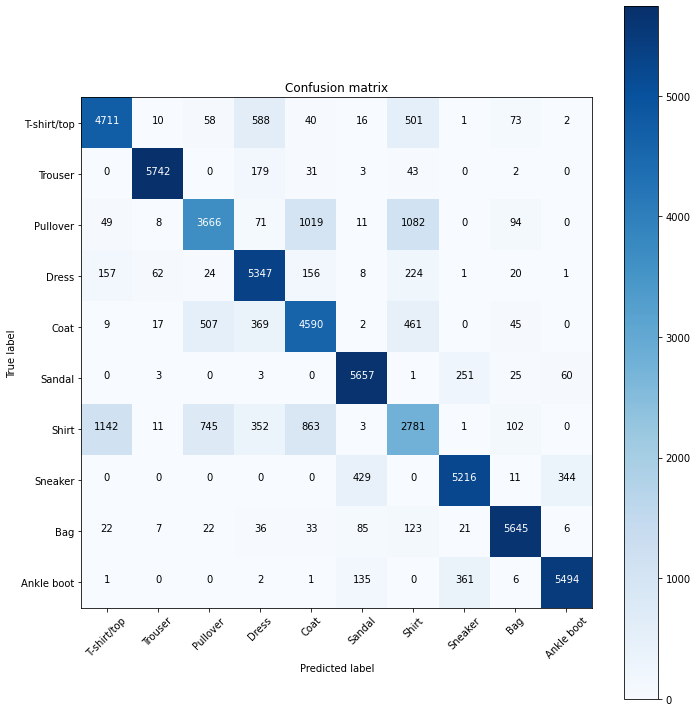

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, train_set.classes)

### 解释混淆矩阵
---

混淆矩阵具有三个轴：

* 预测标签

* 真实标签

* 热图值（彩色）

预测标签和真实标签向我们显示了我们正在处理的预测类。 矩阵对角线表示矩阵中预测和真值相同的位置，因此我们希望此处的热图更暗。

任何不在对角线上的值都是不正确的预测，因为预测和真实标签不匹配。 要读取该图，我们可以使用以下步骤：

* 在水平轴上选择一个预测标签。

* 检查该标签的对角线位置以查看正确的总数。

* 检查其他非对角线位置以查看网络混乱之处。

如果我们考虑一下，这是很有意义的。 随着我们模型的学习，我们将看到对角线之外的数字越来越小。


## 总结

至此，我们已经完成了许多在PyTorch中构建和训练CNN的工作。